## Load libraries

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%reload_ext XTIPython

You can now access BridgeLib, ImarisLib, vImaris, vDataSet, vScene and vFactory


In [3]:
%imaris_pull surfaces

['WT Th1  outside CXCL10 cluster',
 'Surfaces 1',
 'CXCR3 KO Th1 outside CXCL10 cluster',
 'WT Th1  inside CXCL10 cluster',
 'WT Th1 ',
 'CXCL10 cells',
 'WT Th1:CXCL10  contacts',
 'CXCR3 KO Th1 inside CXCL10 cluster',
 'CXCR3 KO Th1']

In [4]:
import Tkinter as tk
import Tkconstants, tkFileDialog

In [5]:
%pylab inline

import pandas as pd
from tqdm import tqdm

Populating the interactive namespace from numpy and matplotlib


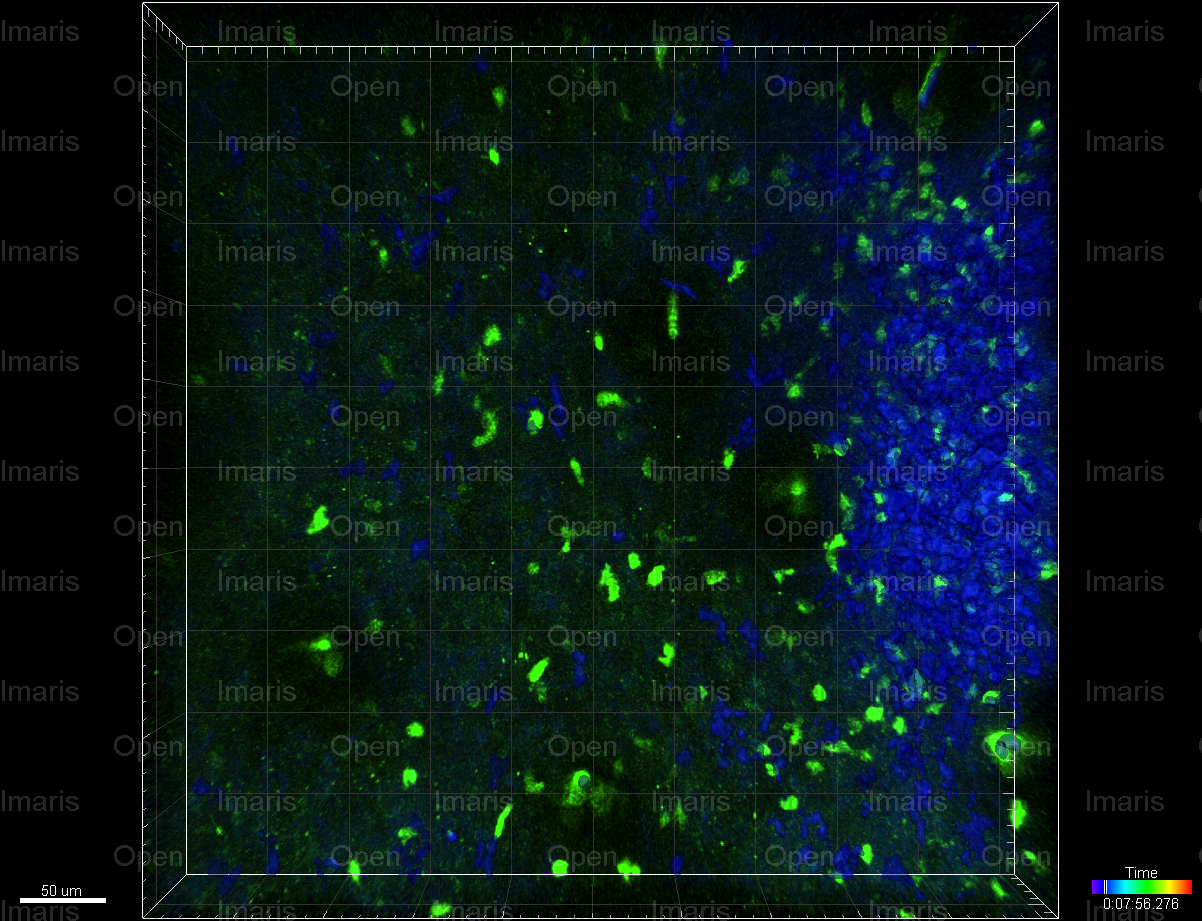

In [6]:
%imaris_screenshot

## Get All Statistics

In [6]:
def get_all_stats(object_type, name):
    
    ## Get object connection for cell collection in Imaris
    
    object_cells = object_type[name]
    object_cell_stats = object_cells.GetStatistics()

    ## Get individual cell IDs and track IDs to create set of edges which form a track
    
    cells = object_cells.GetIds()
    tracks = object_cells.GetTrackIds()
    edges_indices = object_cells.GetTrackEdges()
    edges = [ [str(cells[start]),str(cells[stop])] for [start,stop] in edges_indices]
    
    track_cell_mapping = {}
    for trackID,(start,stop) in zip(tracks,edges_indices):

        start = cells[start]
        stop  = cells[stop]

        track_cell_mapping[str(start)] = str(trackID)
        track_cell_mapping[str(stop)]  = str(trackID)

    track_cell_mapping_df = pd.DataFrame.from_dict(track_cell_mapping,orient='index')
    track_cell_mapping_df.reset_index(inplace=True)
    track_cell_mapping_df.columns = ['objectID','trackID']

    stats_df = pd.DataFrame({'objectID':[str(objid) for objid in object_cell_stats.mIds],
                             'names':object_cell_stats.mNames,
                             'values':object_cell_stats.mValues})

    stats_track_df = pd.merge(left=track_cell_mapping_df,
                              right=stats_df,
                              how='inner')
    
    stats_pivot = stats_track_df.pivot_table(index=['trackID','objectID'],
                                             columns='names',
                                             values='values')
    stats_pivot_df = stats_pivot.reset_index()
    stats_pivot_df['time'] = stats_pivot_df.loc[:,'Time Index']
    
    return(stats_pivot_df)

### Testing

#### Give Object Type

In [10]:
object_type = 'surfaces'

In [11]:
imaris_objects = BridgeLib.GetSurpassObjects(vImaris,object_type)

In [18]:
imaris_objects.keys()

['T cells', 'FN', 'SHG']

#### Give Object Name

In [19]:
object_name = 'T cells'

In [20]:
all_stats = get_all_stats(imaris_objects, object_name)

#### Select and write dataset

In [21]:
columns_to_use = ['trackID','objectID', 'time', 'Position X', 'Position Y', 'Position Z']
data = all_stats.loc[:,columns_to_use].copy()
data.columns = ['trackID','objectID', 'time', 'x', 'y', 'z']

data.head(2)

,trackID,objectID,time,x,y,z
0,1000005470,5470,1.0,27.063908,280.285400,48.121212
1,1000005470,5562,2.0,27.263998,280.428711,48.285713


In [22]:
df = data.loc[data.time==1].copy()
df.reset_index(drop=True, inplace=True)

In [24]:
path_to_output = 'D:/projects/bio-imaging/test.csv'

In [ ]:
df.to_csv(path_to_output)